In [67]:
train_dataset = 'C:/Users/iamso/DataspellProjects/virtuka_classification/data/Face Shape 7s/Face Shape/Train'
test_dataset = 'C:/Users/iamso/DataspellProjects/virtuka_classification/data/Face Shape 7s/Face Shape/Test'

In [68]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rotation_range=20, horizontal_flip=True, rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dataset,  # This is the source directory for training images
    target_size=(224, 224),  # All images will be resized to 224 x 224
    batch_size=32,
    # Specify the classes explicitly
    classes = ['Diamond','Oblong','Oval','Round','Square','Triangle'],
    # Since we use categorical_crossentropy loss, we need categorical labels
    class_mode='categorical')

Found 3600 images belonging to 6 classes.


In [69]:
# Initialize an ImageDataGenerator object for test data augmentation
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(
    test_dataset,  # Directory of test data
    shuffle=False,  # Not shuffled
    batch_size=32,  # Batch size
    classes=['Diamond', 'Oblong', 'Oval', 'Round', 'Square', 'Triangle'],  # Target classes
    target_size=(224, 224),  # Desired image size
    class_mode='categorical'  # Categorical class mode
)


Found 1200 images belonging to 6 classes.


In [70]:
# Create a dictionary to map numerical class indices to corresponding class labels
labels = {value: key for key, value in train_generator.class_indices.items()}

# Print label mappings for classes present in the training and validation datasets
print("Label Mappings for classes present in the training and validation datasets\n")

# Iterate through the dictionary and print each numerical index and its corresponding class label
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : Diamond
1 : Oblong
2 : Oval
3 : Round
4 : Square
5 : Triangle


In [71]:
# Import the TensorFlow library
import tensorflow as tf

# Load a pre-trained convolutional neural network (CNN) model from a specified file path
model_cnn = tf.keras.models.load_model('C:/Users/iamso/DataspellProjects/virtuka_classification/virtuka_model_cnn_fix/virtuka_cnn_aug_v1_95%_sofyan.h5')


In [72]:
predictions = model_cnn.predict(test_generator)

38/38 [==============================] - 9s 214ms/step


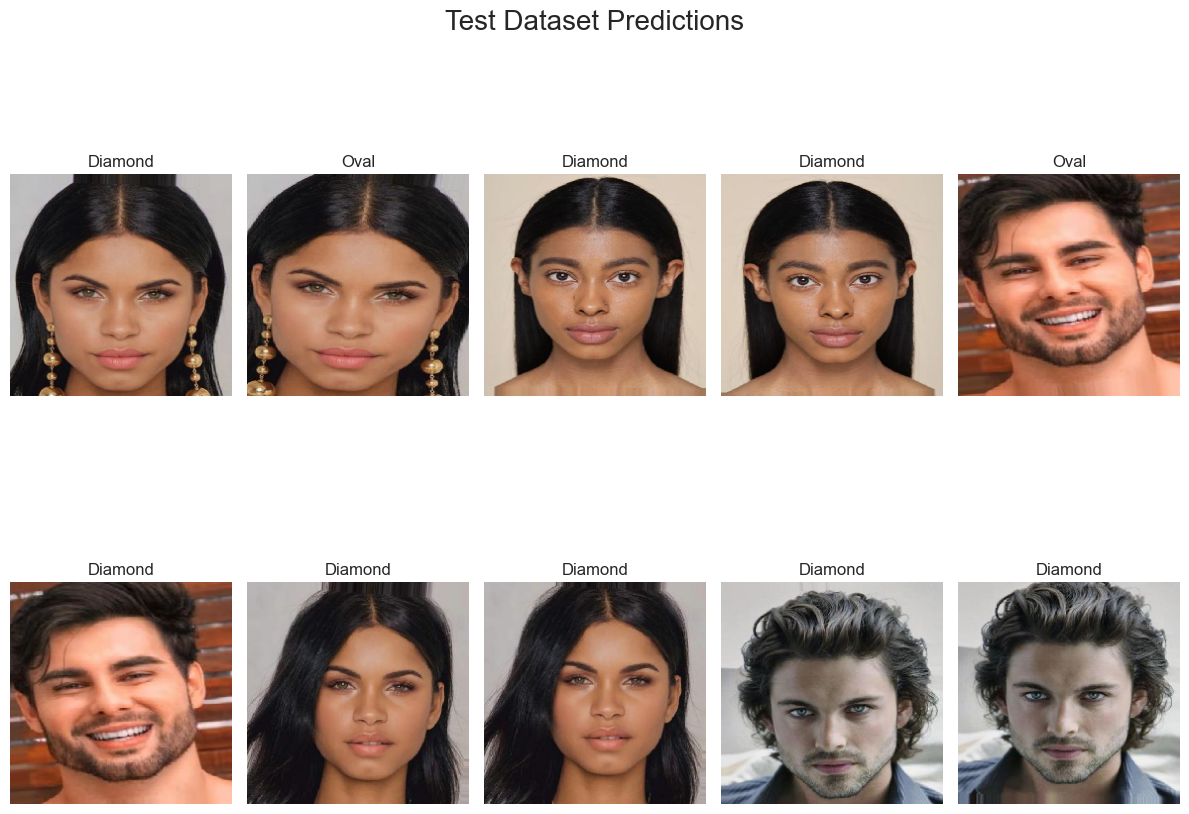

In [73]:
import matplotlib.pyplot as plt
import numpy as np

# Create a subplot with 2 rows and 5 columns, setting the figure size
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))

# Initialize the index variable
idx = 0

# Iterate over the rows
for i in range(2):
    # Iterate over the columns
    for j in range(5):
        # Get the predicted label using the numerical index with the highest probability
        predicted_label = labels[np.argmax(predictions[idx])]

        # Set the title of the subplot with the predicted label
        ax[i, j].set_title(f"{predicted_label}")

        # Display the image from the test generator
        ax[i, j].imshow(test_generator[0][0][idx])

        # Turn off axis labels
        ax[i, j].axis("off")

        # Increment the index
        idx += 1

# Adjust layout for better presentation
plt.tight_layout()

# Add a title to the entire plot
plt.suptitle("Test Dataset Predictions", fontsize=20)

# Display the plot
plt.show()


In [74]:
# Evaluate the pre-trained convolutional neural network (CNN) model on the test data generator
# Obtain the test loss and test accuracy
test_loss, test_accuracy = model_cnn.evaluate(test_generator, batch_size=32)

38/38 [==============================] - 7s 184ms/step - loss: 0.0969 - accuracy: 0.9733


In [75]:
# Obtain the predicted class indices by selecting the index with the highest probability for each sample
y_pred = np.argmax(predictions, axis=1)

# Obtain the true class indices from the test generator
y_true = test_generator.classes

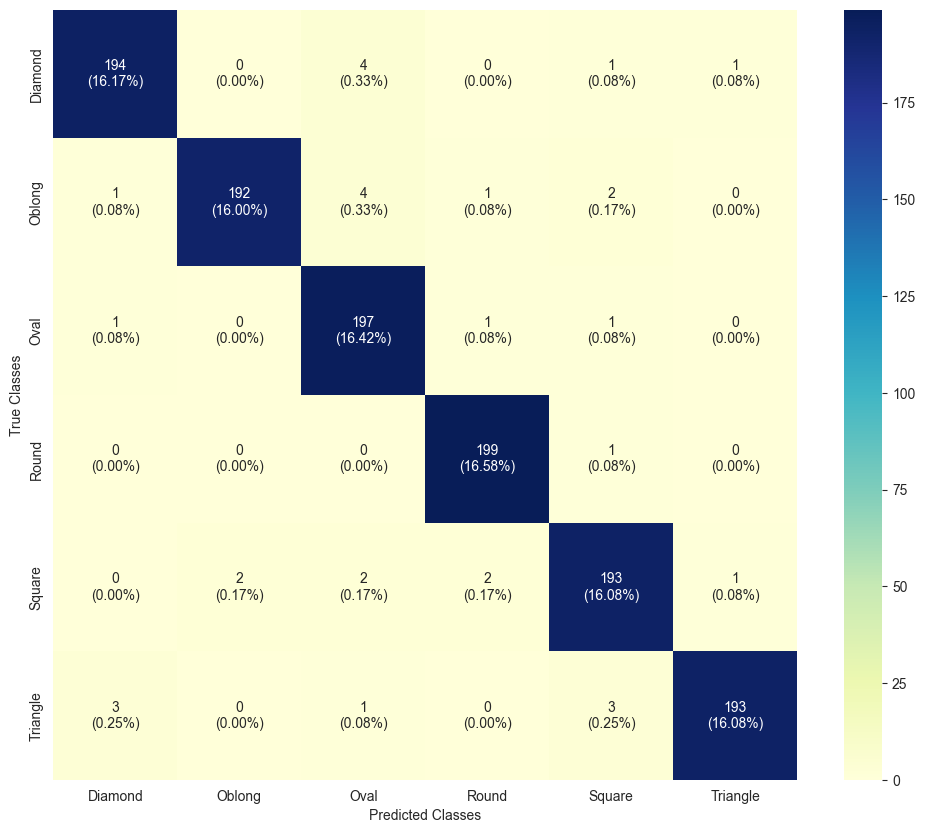

In [76]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix using true and predicted class indices
cf_mtx = confusion_matrix(y_true, y_pred)

# Prepare counts, percentages, and labels for the confusion matrix visualization
group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(6, 6)

# Set up the figure for the heatmap visualization
plt.figure(figsize=(12, 10))

# Create a heatmap using seaborn with the confusion matrix values
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
            cmap="YlGnBu", fmt="", annot=box_labels)

# Set labels for the axes
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')

# Display the heatmap
plt.show()


In [77]:
from sklearn.metrics import classification_report

# Generate a classification report based on true and predicted class indices
# Specify target names for better readability using label values
report = classification_report(y_true, y_pred, target_names=labels.values())

# Print the classification report
print(report)


              precision    recall  f1-score   support

     Diamond       0.97      0.97      0.97       200
      Oblong       0.99      0.96      0.97       200
        Oval       0.95      0.98      0.97       200
       Round       0.98      0.99      0.99       200
      Square       0.96      0.96      0.96       200
    Triangle       0.99      0.96      0.98       200

    accuracy                           0.97      1200
   macro avg       0.97      0.97      0.97      1200
weighted avg       0.97      0.97      0.97      1200


In [78]:
# Identify errors by comparing true class indices with predicted class indices
errors = (y_true - y_pred != 0)

# Extract true class indices for the samples with errors
y_true_errors = y_true[errors]

# Extract predicted class indices for the samples with errors
y_pred_errors = y_pred[errors]

In [79]:
# Get the filenames of the test images from the test generator
test_images = test_generator.filenames

# Select the filenames corresponding to the samples with errors
test_img = np.asarray(test_images)[errors]


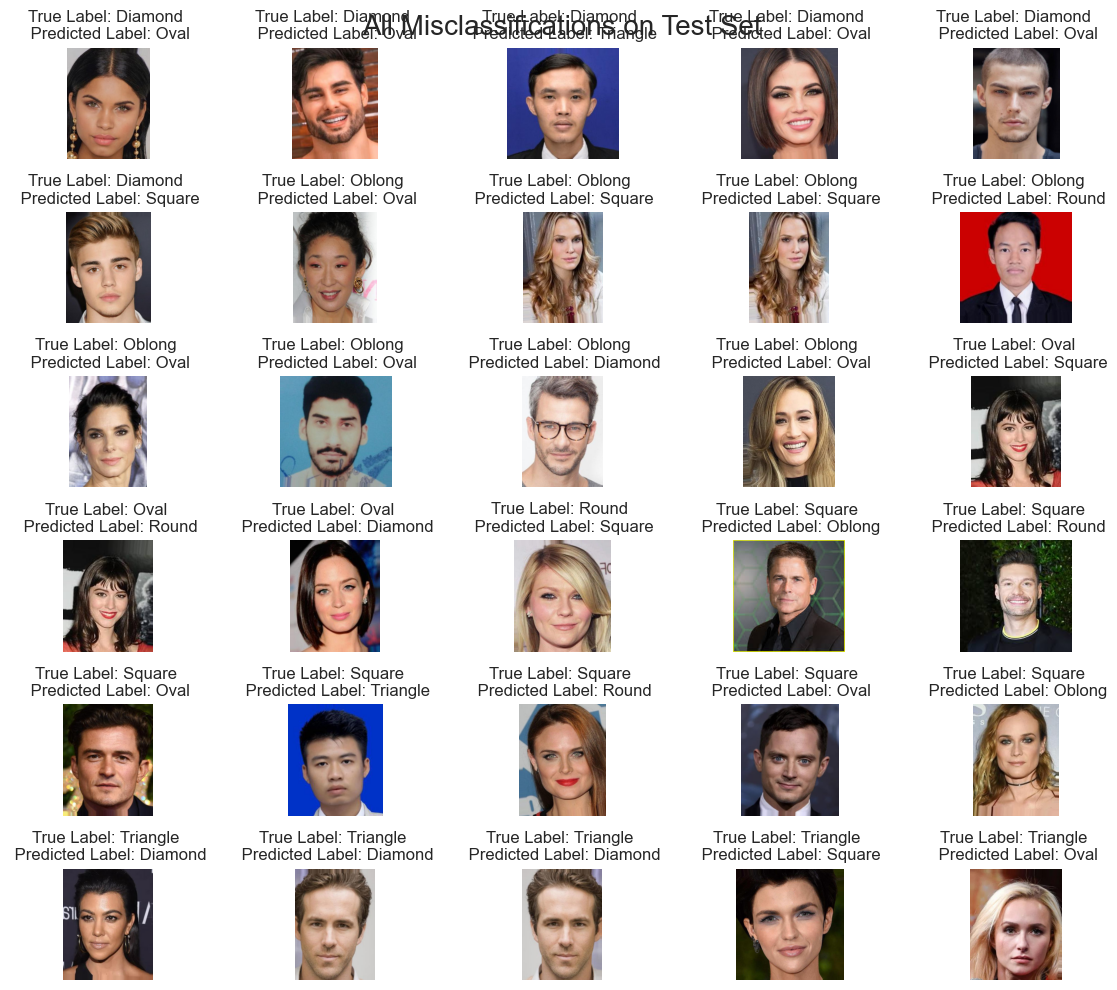

In [80]:
import os
import cv2

# Function to visualize all misclassified data
def visualize_all_misclassifications(model, test_generator, labels):

    # Get indices of true and mispredicted class labels
    errors = (y_true - y_pred != 0)
    y_true_errors = y_true[errors]
    y_pred_errors = y_pred[errors]
    test_images = np.asarray(test_generator.filenames)[errors]

    # Create a subplot with the specified number of rows and columns
    fig, ax = plt.subplots(nrows=len(test_images) // 5, ncols=5, figsize=(12, 10))

    # Iterate over the subplots
    for i in range(len(test_images) // 5):
        for j in range(5):
            # Get indices of misclassified data
            idx = i * 5 + j

            # Get indices of true and predicted class labels
            true_index = y_true_errors[idx]
            true_label = labels[true_index]
            predicted_index = y_pred_errors[idx]
            predicted_label = labels[predicted_index]

            # Set the title of the subplot with true and predicted labels
            ax[i, j].set_title(f"True Label: {true_label} \n Predicted Label: {predicted_label}")

            # Get the file path for the selected image
            img_path = os.path.join(test_dataset, test_images[idx])

            # Read the image using OpenCV and convert color from BGR to RGB
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Display the image in the subplot and turn off axis labels
            ax[i, j].imshow(img)
            ax[i, j].axis("off")

    # Adjust layout for better presentation
    plt.tight_layout()

    # Add a title to the entire plot
    plt.suptitle('All Misclassifications on Test Set', fontsize=20)

    # Display the plot
    plt.show()

# Call the function to visualize all misclassified data
visualize_all_misclassifications(model_cnn, test_generator, labels)


In [81]:
from tabulate import tabulate

# Calculate and print the total number of misclassifications
total_misclassifications = np.sum(y_true != y_pred)
print(f"\nTotal Misclassifications: {total_misclassifications}")

# Calculate and print the number of misclassifications for each class
misclassifications_per_class = {}
for label in labels.values():
    true_indices = np.where(y_true == labels_reverse[label])
    misclassified_indices = true_indices[0][y_true[true_indices] != y_pred[true_indices]]
    misclassifications_per_class[label] = len(misclassified_indices)

# Create a list of lists for tabulate
table_data = [["Class", "Misclassifications"]]
for label, misclassifications in misclassifications_per_class.items():
    table_data.append([label, misclassifications])

# Print the table
print(tabulate(table_data, headers="firstrow", tablefmt="fancy_grid"))



Total Misclassifications: 32
╒══════════╤══════════════════════╕
│ Class    │   Misclassifications │
╞══════════╪══════════════════════╡
│ Diamond  │                    6 │
├──────────┼──────────────────────┤
│ Oblong   │                    8 │
├──────────┼──────────────────────┤
│ Oval     │                    3 │
├──────────┼──────────────────────┤
│ Round    │                    1 │
├──────────┼──────────────────────┤
│ Square   │                    7 │
├──────────┼──────────────────────┤
│ Triangle │                    7 │
╘══════════╧══════════════════════╛


In [83]:
# Calculate and print the total number of correct classifications
total_correct_classifications = np.sum(y_true == y_pred)
print(f"\nTotal Correct Classifications: {total_correct_classifications}")

# Calculate and print the number of correct classifications for each class
correct_classifications_per_class = {}
for label in labels.values():
    true_indices = np.where(y_true == labels_reverse[label])
    correct_indices = true_indices[0][y_true[true_indices] == y_pred[true_indices]]
    correct_classifications_per_class[label] = len(correct_indices)

# Create a list of lists for tabulate
table_data_correct = [["Class", "Correct Classifications"]]
for label, correct_classifications in correct_classifications_per_class.items():
    table_data_correct.append([label, correct_classifications])

# Print the table for correct classifications
print(tabulate(table_data_correct, headers="firstrow", tablefmt="fancy_grid"))


Total Correct Classifications: 1168
╒══════════╤═══════════════════════════╕
│ Class    │   Correct Classifications │
╞══════════╪═══════════════════════════╡
│ Diamond  │                       194 │
├──────────┼───────────────────────────┤
│ Oblong   │                       192 │
├──────────┼───────────────────────────┤
│ Oval     │                       197 │
├──────────┼───────────────────────────┤
│ Round    │                       199 │
├──────────┼───────────────────────────┤
│ Square   │                       193 │
├──────────┼───────────────────────────┤
│ Triangle │                       193 │
╘══════════╧═══════════════════════════╛


38/38 [==============================] - 7s 195ms/step


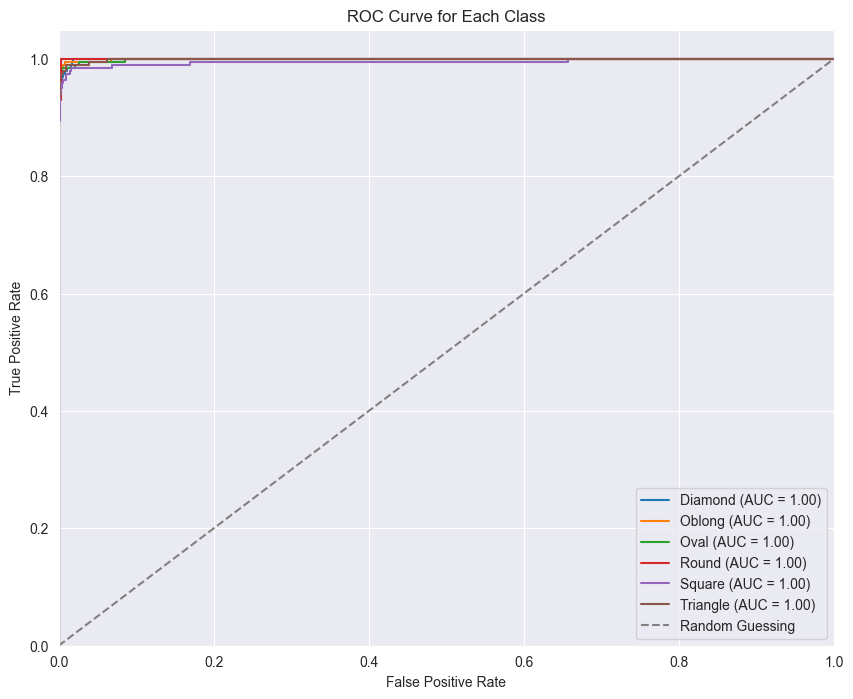

In [84]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Convert labels to one-hot encoding
y_true_one_hot = label_binarize(y_true, classes=np.unique(y_true))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Get predicted probabilities for each class
y_score = model_cnn.predict(test_generator)

# Compute ROC curve and ROC area for each class
for i in range(len(labels)):
    fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(len(labels)):
    plt.plot(fpr[i], tpr[i], label=f'{labels[i]} (AUC = {roc_auc[i]:.2f})')

# Plot random guessing line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')

# Set plot properties
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc='lower right')
plt.show()


In [85]:
# Get predicted probabilities for each class
probabilities = model_cnn.predict(test_generator)

# Convert probabilities to percentages
probabilities_percentage = probabilities * 100

# Example: Display probabilities for some samples
for i in range(400):  # Display probabilities for the first n samples
    print(f"Probabilities for sample {i}:")
    for class_idx, class_prob in enumerate(probabilities_percentage[i]):
        print(f"  Class {class_idx}: {class_prob:.2f}%")

# If you want to get the class label with the highest probability, you can use argmax
predicted_labels = np.argmax(probabilities, axis=1)

# predicted_labels now contains the predicted class labels for each sample


38/38 [==============================] - 7s 185ms/step
Probabilities for sample 0:
  Class 0: 60.68%
  Class 1: 0.00%
  Class 2: 0.00%
  Class 3: 38.70%
  Class 4: 0.20%
  Class 5: 0.42%
Probabilities for sample 1:
  Class 0: 5.36%
  Class 1: 0.11%
  Class 2: 43.71%
  Class 3: 13.96%
  Class 4: 1.16%
  Class 5: 35.71%
Probabilities for sample 2:
  Class 0: 100.00%
  Class 1: 0.00%
  Class 2: 0.00%
  Class 3: 0.00%
  Class 4: 0.00%
  Class 5: 0.00%
Probabilities for sample 3:
  Class 0: 100.00%
  Class 1: 0.00%
  Class 2: 0.00%
  Class 3: 0.00%
  Class 4: 0.00%
  Class 5: 0.00%
Probabilities for sample 4:
  Class 0: 30.08%
  Class 1: 0.00%
  Class 2: 69.92%
  Class 3: 0.00%
  Class 4: 0.00%
  Class 5: 0.00%
Probabilities for sample 5:
  Class 0: 70.16%
  Class 1: 0.00%
  Class 2: 29.83%
  Class 3: 0.00%
  Class 4: 0.00%
  Class 5: 0.00%
Probabilities for sample 6:
  Class 0: 100.00%
  Class 1: 0.00%
  Class 2: 0.00%
  Class 3: 0.00%
  Class 4: 0.00%
  Class 5: 0.00%
Probabilities for sa